#Import the Libraries

In [ ]:
# install rouge-score library
!pip install -q rouge-score

In [ ]:
# install contractions library
!pip install -q contractions

     |████████████████████████████████| 286kB 8.5MB/s 
     |████████████████████████████████| 327kB 12.7MB/s 


In [ ]:
import numpy as np
import pandas as pd 
import re
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
pd.set_option("display.max_colwidth", 200)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Amazon Fine Food Reviews Dataset:
This dataset consists of reviews on food products. For each review the customer writes a long review, and a short concise summary about his review. We will download the dataset from Kaggle using the Kaggle API.

In [ ]:
# upload the kaggle.json API file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shaffei","key":"1c13d86e3bc149176fdb5ffbba3989a1"}'}

In [ ]:
# copy the json file to where the API expects 
! cp kaggle.json ~/.kaggle/
# change the permission of the json file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download the dataset
!kaggle datasets download -d snap/amazon-fine-food-reviews

 93% 226M/242M [00:01<00:00, 127MB/s]
100% 242M/242M [00:01<00:00, 140MB/s]


In [ ]:
# extract the dataset
!unzip -q amazon-fine-food-reviews.zip

In [ ]:
# read the data
df = pd.read_csv('Reviews.csv')

## Take a look at the dataset

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


## Drop duplicate rows and/or missing values

In [ ]:
df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True)

## Now let's inspect the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393565 non-null  int64 
 1   ProductId               393565 non-null  object
 2   UserId                  393565 non-null  object
 3   ProfileName             393565 non-null  object
 4   HelpfulnessNumerator    393565 non-null  int64 
 5   HelpfulnessDenominator  393565 non-null  int64 
 6   Score                   393565 non-null  int64 
 7   Time                    393565 non-null  int64 
 8   Summary                 393565 non-null  object
 9   Text                    393565 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


# Preprocessing

## First of all the dataset contains aroud 400,000 training examples which is very huge, and will make training very slow. We will only use 100,000 training examples. 

In [ ]:
# take a copy from the original dataset and clean it
df_clean = df.copy()

In [ ]:
# include only 100,000 training examples
max_examples = 100000
df_clean = df_clean[:max_examples]

## We will only include the review and summary columns and drop other columns

In [ ]:
for column in df_clean.columns:
  if column not in ['Text', 'Summary']:
    df_clean.drop(columns=column, inplace=True)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 114551
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  100000 non-null  object
 1   Text     100000 non-null  object
dtypes: object(2)
memory usage: 4.8+ MB


## We will perform the below preprocessing tasks for our data:

1.Normalize all characters to lowercase

2.Expanding contractions

3.Remove (‘s)

4.Remove any text inside the parenthesis ( )

5.Eliminate punctuations and special characters

6.Remove stopwords

## We expand the contractions to allow the model to learn the same representation for words with the same meaning but with/without contractions

In [ ]:
import contractions

def expand_text(df):
  for col in df.columns:
    df[col] = df[col].apply(contractions.fix) # fix contractions for each column

In [ ]:
expand_text(df_clean) # fix contraction for the dataset
df_clean.head()  # take a look at the dataset after contractions fixing

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [ ]:
def clean_text(df, column, remove_stopwords = True):
  '''
  Clean the text in the giveon column 
  '''
  # normalize all characters to lowercase
  df[column] = df[column].str.lower()
  # remove any text between parenthes and the parenthes
  df[column] = df[column].apply(lambda text: re.sub(r'\([^)]*\)', '', text))
  # remove any 's used for possession
  df[column] = df[column].apply(lambda text: re.sub(r"'s\b","",text))
  # replace any punctuation by a whitespace
  df[column] = df[column].apply(lambda text: re.sub(r"[^a-zA-Z1-9 ]", " ", text))
  if remove_stopwords:
    # create a set of stopwords
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    # remove stopwords
    df[column] = df[column].apply(lambda text: " ".join([w for w in text.split() if w not in stop_words]))
  # finally strip all articles from any leading or trailing whitespaces
  df[column] = df[column].str.strip()

In [ ]:
# clean text in reviews
clean_text(df_clean, 'Text')
# clean text in summaries
clean_text(df_clean, 'Summary', False)

df_clean.head()

,Summary,Text
0,good quality dog food,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
1,not as advertised,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
2,delight says it all,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...
3,cough medicine,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
4,great taffy,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal


## Drop empty rows which happen when the cleaning process removes all words in the 

In [ ]:
# check if any row in the text contains no words
df_clean.Text.str.len().min()

12

In [ ]:
# check if any row in the Summaries contains no words
df_clean.Summary.str.len().min()

0

In [ ]:
# Remove rows with empty summaries
df_clean = df_clean.drop(df_clean[df_clean.Summary.str.len() == 0].index)
# validate
df_clean.Summary.str.len().min()

1

## We need to fix a certain length for all reviews, and a fixed length for all summaries. To do so we start inspecing the length distribution of reviews and summaries

In [ ]:
# get an idea of the reviews lengths
max_review_len = df_clean.Text.str.len().max()
avg_review_len = df_clean.Text.str.len().mean()
median_review_len = df_clean.Text.str.len().median()

print("Maximum review length is", max_review_len)
print("Average review length is", avg_review_len)
print("Median review length is", median_review_len)

Maximum review length is 9212
Average review length is 260.30798524934437
Median review length is 182.0


In [ ]:
# get an idea of the summaries lengths
max_summary_len = df_clean.Summary.str.len().max()
avg_summary_len = df_clean.Summary.str.len().mean()
median_summary_len = df_clean.Summary.str.len().median()

print("Maximum summary length is", max_summary_len)
print("Average summary length is", avg_summary_len)
print("Median summary length is", median_summary_len)

Maximum summary length is 130
Average summary length is 22.822138041217432
Median summary length is 20.0


In [ ]:
max_text_len = 30
max_summary_len = 10

## We need  to add start and end tokens for the summary to allow the decoder to work properly

In [ ]:
df_clean.Summary = df_clean.Summary.apply(lambda x : 'sostok '+ x + ' eostok')

## We split the dataset into train validation sets with 90% train split and 10% validation split

In [ ]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df_clean.Text),np.array(df_clean.Summary),test_size=0.1,random_state=0,shuffle=True) 

## Now let's tokenize the sentences

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

#Summary Tokenizer

In [ ]:
#prepare a tokenizer for summaries on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

## We set a threhsold of 4 occurences for words to be included in our tokens

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

## Tokenize only the most occuring words

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

# Model
Our model is a sequence to sequence model consisting of an encoder which contains an embedding layer to learn multi dimensional word representations allowing it to understand relation between words. The embedding layer is followed by three LSTM layers that encoder the words embeddings in a representation that the decoder can process properly. The decoder reads the target summary using an embedding layer followed by an LSTM layer. An attention layer allows the decoder to focus its attention on the most relevant words from the review while predicting the next word.

In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     1258300     input_34[0][0]                   
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________________________________________

I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

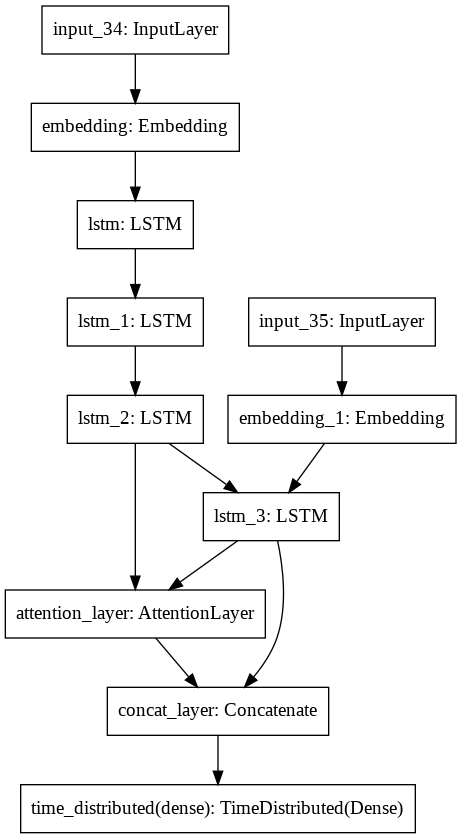

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Remember the concept of early stopping? It is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,callbacks=[es], epochs=50,batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
472/472 [==============================] - 68s 130ms/step - loss: 2.4397 - val_loss: 2.1608
Epoch 2/50
472/472 [==============================] - 59s 125ms/step - loss: 2.1219 - val_loss: 2.0263
Epoch 3/50
472/472 [==============================] - 58s 124ms/step - loss: 2.0027 - val_loss: 1.9564
Epoch 4/50
472/472 [==============================] - 58s 124ms/step - loss: 1.9291 - val_loss: 1.9091
Epoch 5/50
472/472 [==============================] - 58s 124ms/step - loss: 1.8746 - val_loss: 1.8797
Epoch 6/50
472/472 [==============================] - 58s 124ms/step - loss: 1.8306 - val_loss: 1.8587
Epoch 7/50
472/472 [==============================] - 59s 124ms/step - loss: 1.7939 - val_loss: 1.8393
Epoch 8/50
472/472 [==============================] - 58s 123ms/step - loss: 1.7593 - val_loss: 1.8264
Epoch 9/50
472/472 [==============================] - 58s 123ms/step - loss: 1.7300 - val_loss: 1.8160
Epoch 10/50
472/472 [==============================] - 58s 123ms/step - l

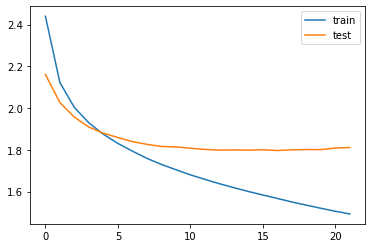

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference

Set up the inference for the encoder and decoder:

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
from rouge_score import rouge_scorer

total_score = 0
scorer = rouge_scorer.RougeScorer(['rouge1' ], use_stemmer=True)
rand_len = 500
ind = np.random.choice(len(y_val), rand_len, replace=False)
for i in ind: 
    score = scorer.score(
                seq2summary(y_val[i]), 
                decode_sequence(x_val[i].reshape(1,max_text_len))
              )
    total_score += score['rouge1'].fmeasure

print('Average rouge-1 on {} random samples = {}%'.format(rand_len, total_score*100/rand_len))

Average rouge-1 on 500 random samples = 15.85642468642469%


Here are a few summaries generated by the model:

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Review: cannot find the oz container of equal in the grocery stores so purchased it on amazon which is easy and it is delivered right to my door 
Original summary: equal large size 
Predicted summary:  great price


Review: while wild ride beef jerky cowboy strips do have good hickory taste and are very tender they are also fairly salty and leave lot of gristle in your mouth also like that it does not have msg but am disapointed that meat likely comes from outside the usa on taste alone my family is split on this jerky with of us liking it and two of us not we all like wild bill hickory smoked jerky ounce package will not likely buy this brand again even if it is on sale 
Original summary: good tasting and tender but 
Predicted summary:  not the best


Review: this rice is very tasty and wholesome used to get it locally but the grocery stores have stopped carrying it thankfully it is still available online 
Original summary: excellent rice 
Predicted summary:  rice


Review: must admit